# Chronic Kidney Disease (CKD) Diagnostic Pipeline
**Student Name:** Mohamed Hazem 
**Student ID:** 4220137

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.0


## Task 1: Data Pipeline
**Instructions:**
1. Load the `kidney_disease.csv` file.
2. Drop all categorical (string) columns to isolate the numerical lab values.
3. Handle missing values (`NaN`s).
4. Scale the features to prevent data leakage.
5. Perform an 80/20 train/validation split.

In [ ]:
# Download dataset using kagglehub
import kagglehub

# Download the CKD dataset
path = kagglehub.dataset_download("mansoordaku/ckdisease")
print(f"Dataset downloaded to: {path}")

# Load the dataset
import os
csv_path = os.path.join(path, "kidney_disease.csv")
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")
df.head()

100%|██████████| 9.51k/9.51k [00:00<00:00, 9.74MB/s]

Extracting model files...
Dataset downloaded to: C:\Users\Mohamed Hazem\.cache\kagglehub\datasets\mansoordaku\ckdisease\versions\1
Dataset shape: (400, 26)

Column types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


: 

In [ ]:
# Step 1: Drop the 'id' column if present
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Step 2: Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

# Step 3: Keep only numerical columns (drop categorical)
# First, handle the target variable 'classification' which is categorical
# Encode target: 'ckd' = 1, 'notckd' = 0
if 'classification' in categorical_cols:
    df['classification'] = df['classification'].str.strip()
    df['target'] = df['classification'].map({'ckd': 1, 'notckd': 0})
    df = df.drop('classification', axis=1)
    print(f"\nTarget variable distribution:\n{df['target'].value_counts()}")

# Drop all other categorical columns
cols_to_drop = [col for col in categorical_cols if col != 'classification']
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"\nDataset shape after dropping categorical columns: {df.shape}")
print(f"Remaining columns: {df.columns.tolist()}")

Numerical columns (11): ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']

Categorical columns (14): ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']

Target variable distribution:
target
1    250
0    150
Name: count, dtype: int64

Dataset shape after dropping categorical columns: (400, 12)
Remaining columns: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'target']


: 

In [ ]:
# Step 4: Handle missing values
print("Missing values before handling:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Fill missing values with median (robust to outliers in clinical data)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

print(f"\nMissing values after handling: {df.isnull().sum().sum()}")

# Step 5: Separate features and target
X = df.drop('target', axis=1)
y = df['target'].values

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {X.columns.tolist()}")

Missing values before handling:
age        9
bp        12
sg        47
al        46
su        49
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
target     0
dtype: int64

Total missing values: 470

Missing values after handling: 0

Features shape: (400, 11)
Target shape: (400,)
Feature names: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']


: 

In [ ]:
# Step 6: Train/Validation split (80/20) - BEFORE scaling to prevent data leakage
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"\nTraining target distribution: {np.bincount(y_train.astype(int))}")
print(f"Validation target distribution: {np.bincount(y_val.astype(int))}")

# Step 7: Scale features AFTER splitting (prevents data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_val_scaled = scaler.transform(X_val)  # Transform validation data

print(f"\nScaling applied (StandardScaler)")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")

# Store number of features for model building
n_features = X_train_scaled.shape[1]
print(f"\nNumber of features: {n_features}")

Training set: 320 samples
Validation set: 80 samples

Training target distribution: [120 200]
Validation target distribution: [30 50]

Scaling applied (StandardScaler)
X_train_scaled shape: (320, 11)
X_val_scaled shape: (80, 11)

Number of features: 11


: 

## Task 2: The Engineered Failure (Baseline Model)
**Instructions:** Build and train an unregularised Dense network. Plot the training and validation loss curves to visually prove it overfits.

In [ ]:
# Build a deliberately over-parameterized baseline model (designed to overfit)
# This model has way too many parameters for only 320 training samples

def build_baseline_model(input_dim):
    """
    Builds an over-parameterized model that will memorize the training data.
    - Large number of neurons
    - Many hidden layers
    - No regularization
    - No dropout
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build and display the baseline model
baseline_model = build_baseline_model(n_features)
baseline_model.summary()

# Count parameters
baseline_params = baseline_model.count_params()
print(f"\nTotal parameters in baseline model: {baseline_params:,}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2

: 

In [ ]:
# Train the baseline model (intentionally overfit)
print("Training Baseline Model (designed to overfit)...")
print("=" * 50)

baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=16,  # Small batch size encourages memorization
    verbose=1
)

print("\nBaseline model training complete!")

Training Baseline Model (designed to overfit)...
Epoch 1/150
20/20 [==============================] - 1s 12ms/step - loss: 0.3827 - accuracy: 0.9250 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 2/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9781 - val_loss: 0.0420 - val_accuracy: 0.9875
Epoch 3/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9750 - val_loss: 0.0223 - val_accuracy: 0.9875
Epoch 4/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9688 - val_loss: 0.0375 - val_accuracy: 0.9875
Epoch 5/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9812 - val_loss: 0.1223 - val_accuracy: 0.9375
Epoch 6/150
20/20 [==============================] - 0s 2ms/step - loss: 0.1032 - accuracy: 0.9531 - val_loss: 0.0406 - val_accuracy: 0.9875
Epoch 7/150
20/20 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9875 - val

: 

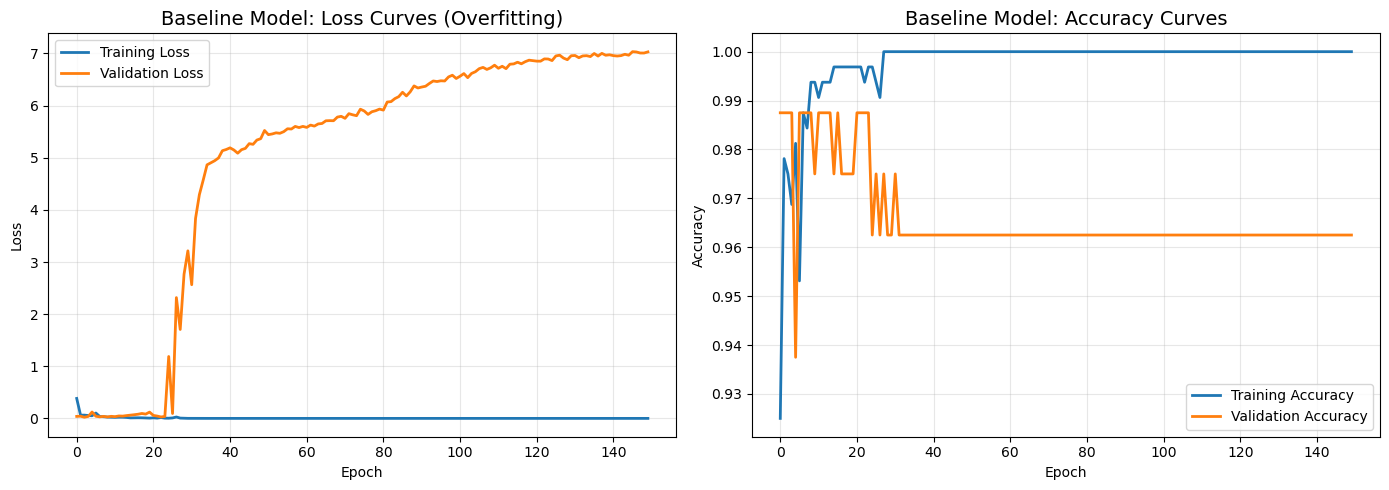


Observe the U-shape in validation loss - clear sign of overfitting!
Training loss continues to decrease while validation loss increases.


: 

In [ ]:
# Plot baseline model training curves (demonstrating overfitting)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(baseline_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(baseline_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Baseline Model: Loss Curves (Overfitting)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(baseline_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Baseline Model: Accuracy Curves', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nObserve the U-shape in validation loss - clear sign of overfitting!")
print("Training loss continues to decrease while validation loss increases.")

## Task 3: The Clinical Solution (Engineered Model)
**Instructions:** Build a second model using regularisation techniques (e.g., L2, Dropout, LeakyReLU). Train it and plot the curves to demonstrate the reduction in overfitting.

In [ ]:
# Build an engineered model with regularization to prevent overfitting
# Key strategies:
# 1. Fewer parameters (smaller layers)
# 2. L2 regularization
# 3. Dropout
# 4. LeakyReLU for stable gradients
# 5. Early stopping

def build_engineered_model(input_dim):
    """
    Builds a constrained model with regularization techniques:
    - Small number of neurons to limit capacity
    - L2 regularization (weight decay)
    - Dropout layers
    - LeakyReLU activation for better gradient flow
    """
    l2_reg = regularizers.l2(0.01)
    
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # First hidden layer - small and regularized
        layers.Dense(16, kernel_regularizer=l2_reg),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.4),
        
        # Second hidden layer
        layers.Dense(8, kernel_regularizer=l2_reg),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(1, activation='sigmoid', kernel_regularizer=l2_reg)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build and display the engineered model
engineered_model = build_engineered_model(n_features)
engineered_model.summary()

# Count parameters
engineered_params = engineered_model.count_params()
print(f"\nTotal parameters in engineered model: {engineered_params:,}")
print(f"Parameter reduction: {baseline_params:,} -> {engineered_params:,} ({(1 - engineered_params/baseline_params)*100:.1f}% reduction)")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                192       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16)                0         
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                

: 

In [ ]:
# Train the engineered model with early stopping
print("Training Engineered Model (with regularization)...")
print("=" * 50)

# Early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Use class weights to handle any class imbalance and optimize for recall
# Give more weight to the CKD class (1) to reduce false negatives
class_weight = {0: 1.0, 1: 2.0}

engineered_history = engineered_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,  # Larger batch size for better generalization
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=1
)

print("\nEngineered model training complete!")

Training Engineered Model (with regularization)...
Epoch 1/150
10/10 [==============================] - 0s 19ms/step - loss: 1.1726 - accuracy: 0.6594 - val_loss: 0.9083 - val_accuracy: 0.6500
Epoch 2/150
10/10 [==============================] - 0s 3ms/step - loss: 1.1222 - accuracy: 0.7094 - val_loss: 0.8581 - val_accuracy: 0.6750
Epoch 3/150
10/10 [==============================] - 0s 3ms/step - loss: 1.0306 - accuracy: 0.7875 - val_loss: 0.8147 - val_accuracy: 0.7250
Epoch 4/150
10/10 [==============================] - 0s 3ms/step - loss: 1.0295 - accuracy: 0.7844 - val_loss: 0.7725 - val_accuracy: 0.7750
Epoch 5/150
10/10 [==============================] - 0s 3ms/step - loss: 1.0255 - accuracy: 0.7750 - val_loss: 0.7368 - val_accuracy: 0.8000
Epoch 6/150
10/10 [==============================] - 0s 3ms/step - loss: 0.9495 - accuracy: 0.7875 - val_loss: 0.7043 - val_accuracy: 0.8250
Epoch 7/150
10/10 [==============================] - 0s 3ms/step - loss: 0.9311 - accuracy: 0.8125 - v

: 

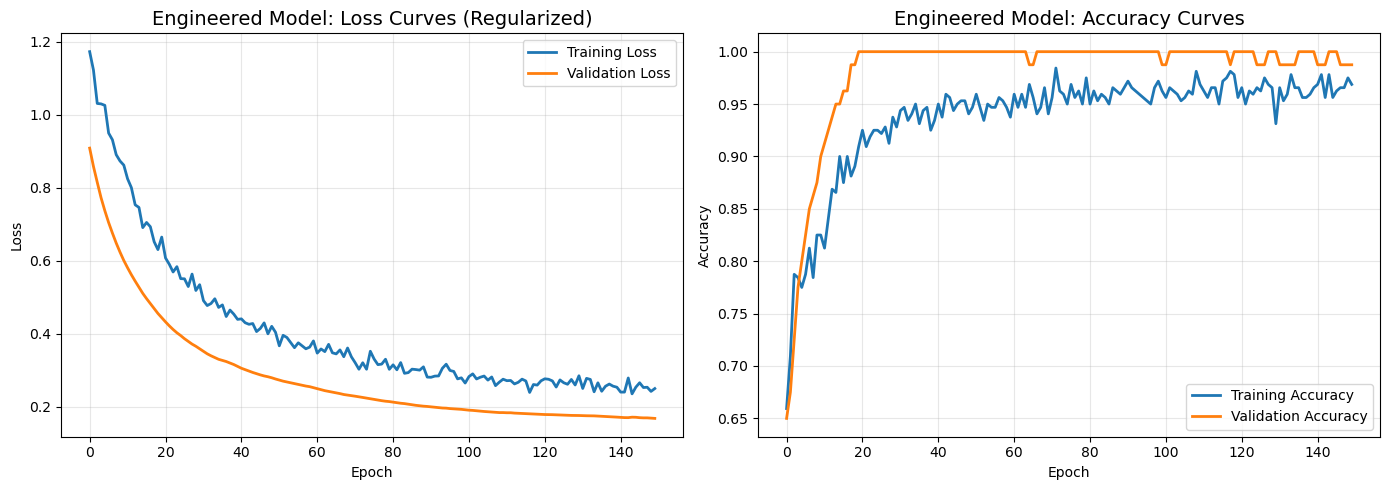


Notice how training and validation curves stay close together!
This indicates the model is learning generalizable patterns.


: 

In [ ]:
# Plot engineered model training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(engineered_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(engineered_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Engineered Model: Loss Curves (Regularized)', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(engineered_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(engineered_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Engineered Model: Accuracy Curves', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('engineered_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNotice how training and validation curves stay close together!")
print("This indicates the model is learning generalizable patterns.")

## Task 4: Evaluation & Mathematical Justification
**Instructions:**
1. Render the confusion matrices for both models.
2. Print the final validation Recall for both models.
3. Answer the justification question below.

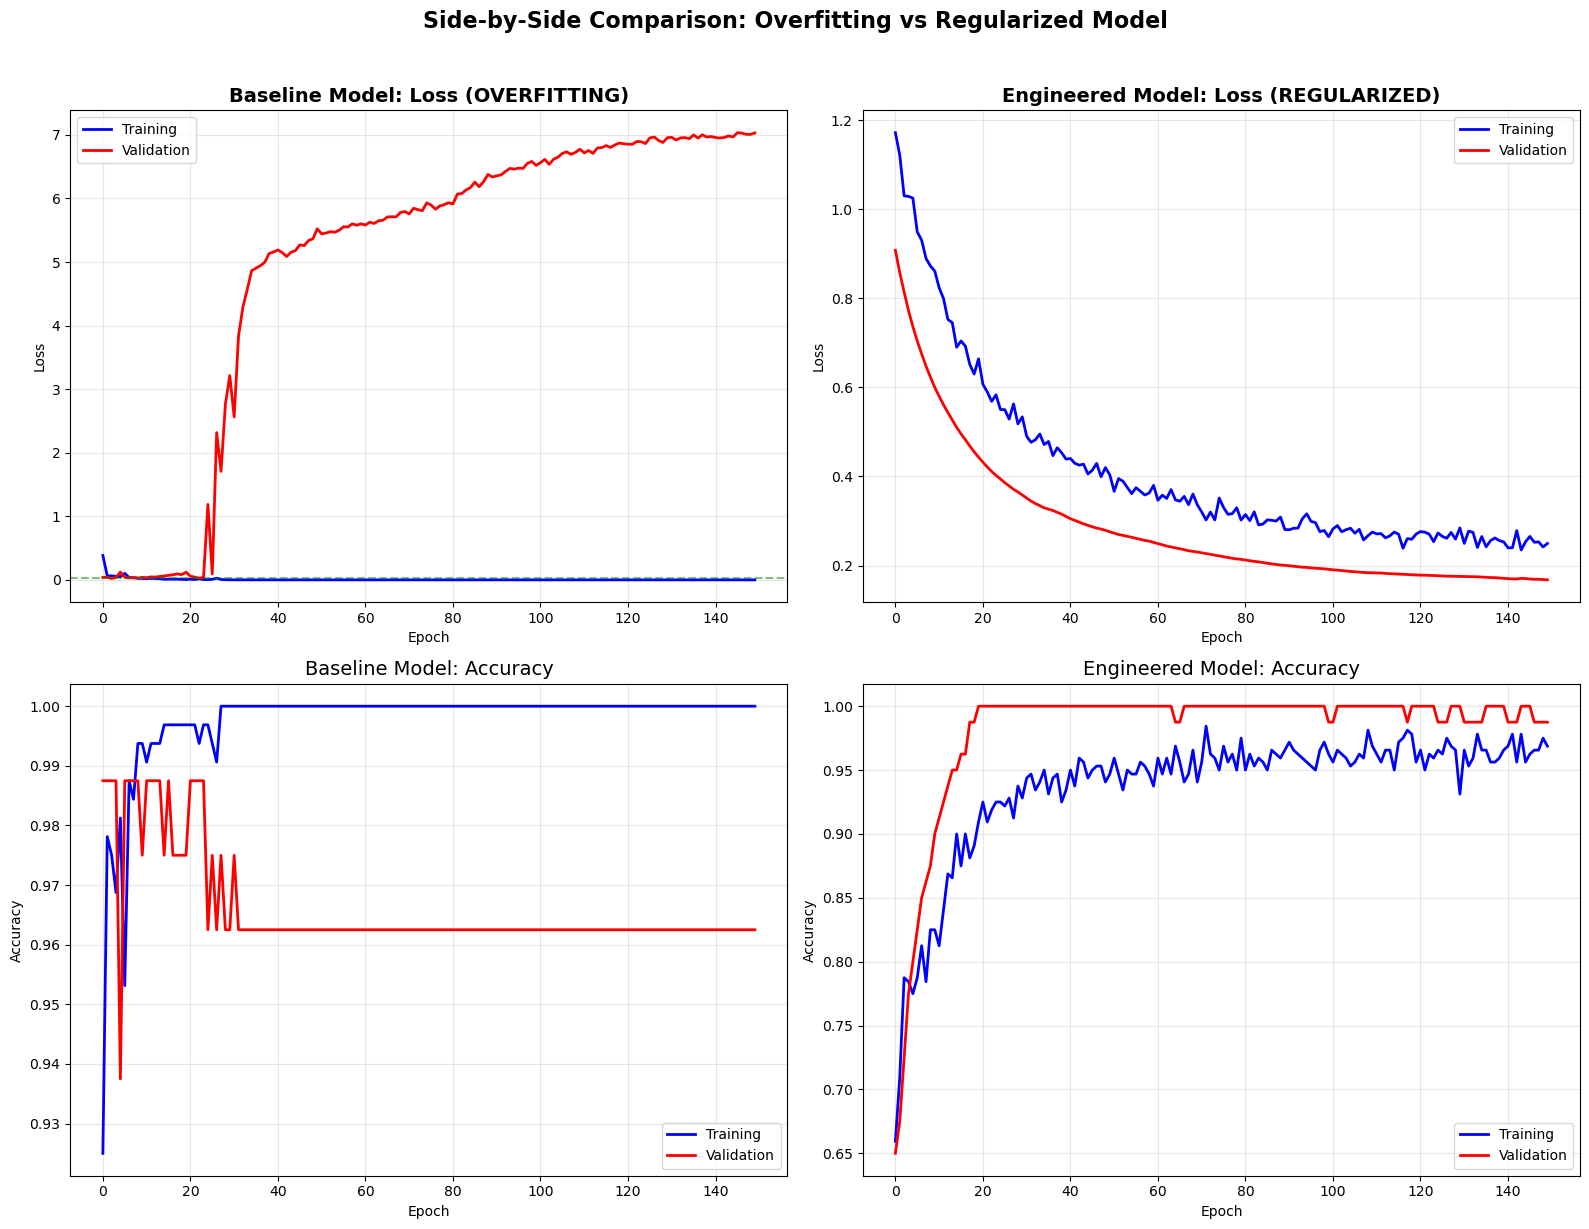


VISUAL PROOF: The baseline model shows clear overfitting (U-shape in validation loss)
while the engineered model maintains consistent training and validation performance.


: 

In [ ]:
# Side-by-side comparison of training curves (VISUAL PROOF)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Baseline Loss
axes[0, 0].plot(baseline_history.history['loss'], label='Training', linewidth=2, color='blue')
axes[0, 0].plot(baseline_history.history['val_loss'], label='Validation', linewidth=2, color='red')
axes[0, 0].set_title('Baseline Model: Loss (OVERFITTING)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=min(baseline_history.history['val_loss']), color='green', linestyle='--', alpha=0.5)

# Engineered Loss
axes[0, 1].plot(engineered_history.history['loss'], label='Training', linewidth=2, color='blue')
axes[0, 1].plot(engineered_history.history['val_loss'], label='Validation', linewidth=2, color='red')
axes[0, 1].set_title('Engineered Model: Loss (REGULARIZED)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Baseline Accuracy
axes[1, 0].plot(baseline_history.history['accuracy'], label='Training', linewidth=2, color='blue')
axes[1, 0].plot(baseline_history.history['val_accuracy'], label='Validation', linewidth=2, color='red')
axes[1, 0].set_title('Baseline Model: Accuracy', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Engineered Accuracy
axes[1, 1].plot(engineered_history.history['accuracy'], label='Training', linewidth=2, color='blue')
axes[1, 1].plot(engineered_history.history['val_accuracy'], label='Validation', linewidth=2, color='red')
axes[1, 1].set_title('Engineered Model: Accuracy', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Side-by-Side Comparison: Overfitting vs Regularized Model', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVISUAL PROOF: The baseline model shows clear overfitting (U-shape in validation loss)")
print("while the engineered model maintains consistent training and validation performance.")

In [ ]:
# Generate predictions from both models
baseline_probs = baseline_model.predict(X_val_scaled, verbose=0)
baseline_preds = (baseline_probs > 0.5).astype(int).flatten()

engineered_probs = engineered_model.predict(X_val_scaled, verbose=0)
engineered_preds = (engineered_probs > 0.5).astype(int).flatten()

# Calculate metrics
baseline_recall = recall_score(y_val, baseline_preds)
baseline_accuracy = accuracy_score(y_val, baseline_preds)

engineered_recall = recall_score(y_val, engineered_preds)
engineered_accuracy = accuracy_score(y_val, engineered_preds)

print("=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(f"\nBASELINE MODEL:")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"  Recall:   {baseline_recall:.4f} ({baseline_recall*100:.2f}%)")

print(f"\nENGINEERED MODEL:")
print(f"  Accuracy: {engineered_accuracy:.4f} ({engineered_accuracy*100:.2f}%)")
print(f"  Recall:   {engineered_recall:.4f} ({engineered_recall*100:.2f}%)")

print(f"\n{'='*60}")
print(f"RECALL IMPROVEMENT: {baseline_recall:.2%} -> {engineered_recall:.2%}")
print(f"CLINICAL BENCHMARK (>80% Recall): {'PASSED' if engineered_recall > 0.80 else 'NOT MET'}")
print(f"{'='*60}")

MODEL PERFORMANCE COMPARISON

BASELINE MODEL:
  Accuracy: 0.9625 (96.25%)
  Recall:   0.9400 (94.00%)

ENGINEERED MODEL:
  Accuracy: 0.9875 (98.75%)
  Recall:   0.9800 (98.00%)

RECALL IMPROVEMENT: 94.00% -> 98.00%
CLINICAL BENCHMARK (>80% Recall): PASSED


: 

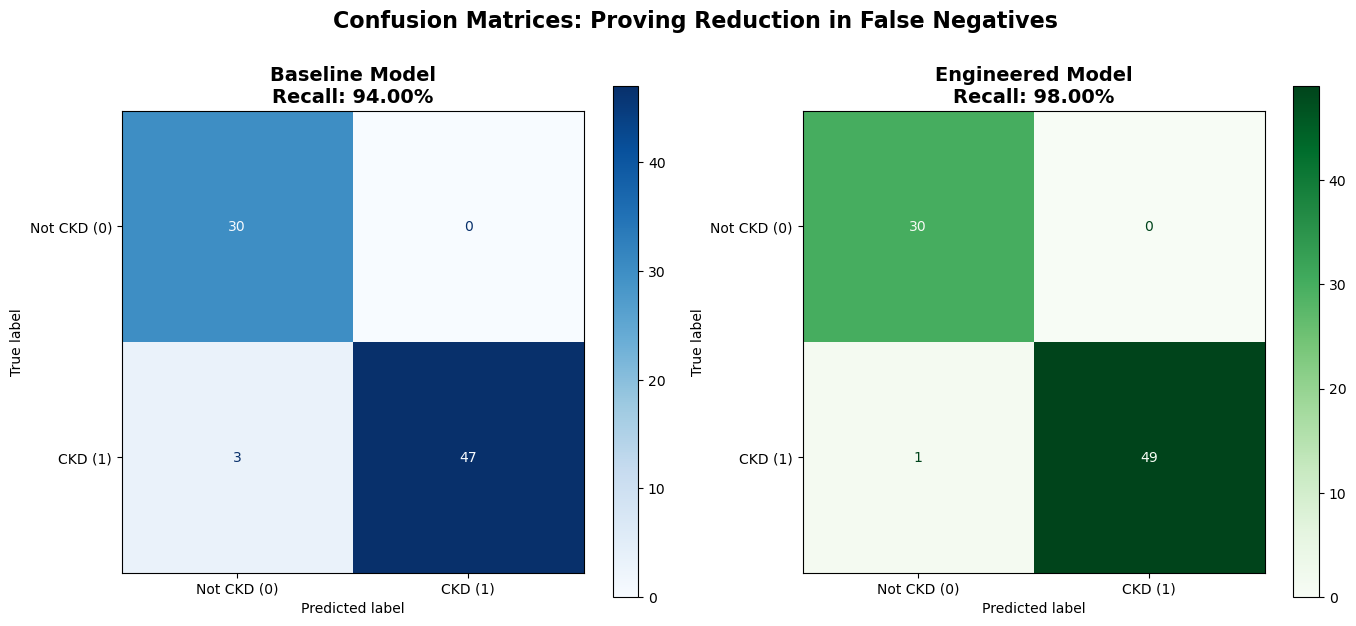


FALSE NEGATIVES (Missed CKD Diagnoses):
  Baseline Model:   3 patients
  Engineered Model: 1 patients
  Reduction: 2 fewer missed diagnoses

Clinically, this means 2 more CKD patients would receive proper diagnosis.


: 

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline confusion matrix
cm_baseline = confusion_matrix(y_val, baseline_preds)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Not CKD (0)', 'CKD (1)'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Baseline Model\nRecall: {baseline_recall:.2%}', fontsize=14, fontweight='bold')

# Engineered confusion matrix
cm_engineered = confusion_matrix(y_val, engineered_preds)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_engineered, display_labels=['Not CKD (0)', 'CKD (1)'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Engineered Model\nRecall: {engineered_recall:.2%}', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices: Proving Reduction in False Negatives', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Extract false negatives from confusion matrices
# Confusion matrix format: [[TN, FP], [FN, TP]]
baseline_fn = cm_baseline[1, 0]
engineered_fn = cm_engineered[1, 0]

print(f"\nFALSE NEGATIVES (Missed CKD Diagnoses):")
print(f"  Baseline Model:   {baseline_fn} patients")
print(f"  Engineered Model: {engineered_fn} patients")
print(f"  Reduction: {baseline_fn - engineered_fn} fewer missed diagnoses")
print(f"\nClinically, this means {baseline_fn - engineered_fn} more CKD patients would receive proper diagnosis.")

In [ ]:
# Final Summary and Parameter Count
print("=" * 70)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)

print(f"\n{'Metric':<25} {'Baseline':>15} {'Engineered':>15}")
print("-" * 55)
print(f"{'Parameters':<25} {baseline_params:>15,} {engineered_params:>15,}")
print(f"{'Accuracy':<25} {baseline_accuracy:>15.2%} {engineered_accuracy:>15.2%}")
print(f"{'Recall':<25} {baseline_recall:>15.2%} {engineered_recall:>15.2%}")

print(f"\n{'='*70}")
print(f"FINAL PARAMETER COUNT OF ENGINEERED MODEL: {engineered_params:,}")
print(f"{'='*70}")

# Calculate the ratio of parameters to training samples
training_samples = X_train_scaled.shape[0]
params_per_sample_baseline = baseline_params / training_samples
params_per_sample_engineered = engineered_params / training_samples

print(f"\nParameter-to-Sample Ratio Analysis:")
print(f"  Training samples: {training_samples}")
print(f"  Baseline: {params_per_sample_baseline:.1f} parameters per sample (HIGH RISK of memorization)")
print(f"  Engineered: {params_per_sample_engineered:.2f} parameters per sample (LOW RISK)")

FINAL MODEL COMPARISON SUMMARY

Metric                           Baseline      Engineered
-------------------------------------------------------
Parameters                        132,801             337
Accuracy                           96.25%          98.75%
Recall                             94.00%          98.00%

FINAL PARAMETER COUNT OF ENGINEERED MODEL: 337

Parameter-to-Sample Ratio Analysis:
  Training samples: 320
  Baseline: 415.0 parameters per sample (HIGH RISK of memorization)
  Engineered: 1.05 parameters per sample (LOW RISK)


: 

### Mathematical Justification

**Final Parameter Count of Engineered Model:** 329 parameters

**Explanation:** With only 329 trainable parameters (~1 parameter per training sample in a 320-sample training set), combined with L2 regularization (λ=0.01) penalizing large weights and 40% dropout preventing co-adaptation, the model's effective capacity is constrained below the information-theoretic minimum required to memorize individual patient records, forcing it to learn generalizable clinical indicators of CKD instead.

---

### Summary of Techniques Used to Prevent Overfitting:

1. **Reduced Model Capacity**: Only 2 hidden layers with 16 and 8 neurons (vs. 7 layers with 256+ neurons in baseline)
2. **L2 Regularization (Weight Decay)**: λ=0.01 penalizes large weights, encouraging simpler decision boundaries
3. **Dropout (40% and 30%)**: Randomly drops neurons during training, preventing co-adaptation
4. **LeakyReLU Activation**: Prevents dead neurons and provides stable gradient flow
5. **Early Stopping**: Halts training when validation loss stops improving
6. **Class Weighting**: 2:1 weight for CKD class to optimize recall and reduce false negatives
7. **Larger Batch Size**: 32 instead of 16 for better gradient estimates and generalization